Homework 4

CS 588 Intro to Big Data Fundamentals

October 28, 2020

Paul Abers

First, let's load in all neccessary modules and load in our iris and indian datasets.

In [149]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from  matplotlib.colors import CSS4_COLORS as mcolors
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.io import loadmat
from scipy.cluster import hierarchy
import warnings
warnings.filterwarnings('ignore')

In [64]:
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
convert_species = np.vectorize(lambda x : "setosa" if x==0 else ("versicolor" if x==1 else "virginica"))
iris_unnamed = iris_df.copy(deep=True)
iris_df["target"] = convert_species(iris.target)
iris_unnamed["target"] = iris.target

In [67]:
indian = loadmat(os.path.join(os.getcwd(), "indianR.mat"))
data = np.array(indian["X"]).T
targets = np.array(indian["gth"])[0]
indian_df = pd.DataFrame(data=data)
indian_df["target"] = targets
indexDrop = indian_df[indian_df["target"] == 0].index
indian_df.drop(indexDrop, inplace=True)
indian_df.reset_index(inplace=True)

Question 1)

a)

With both the iris and indian datasets, loop over the different cluster sizes and collect the cost for each number of clusters. Then plot cost vs clusters for an elbow method plot.

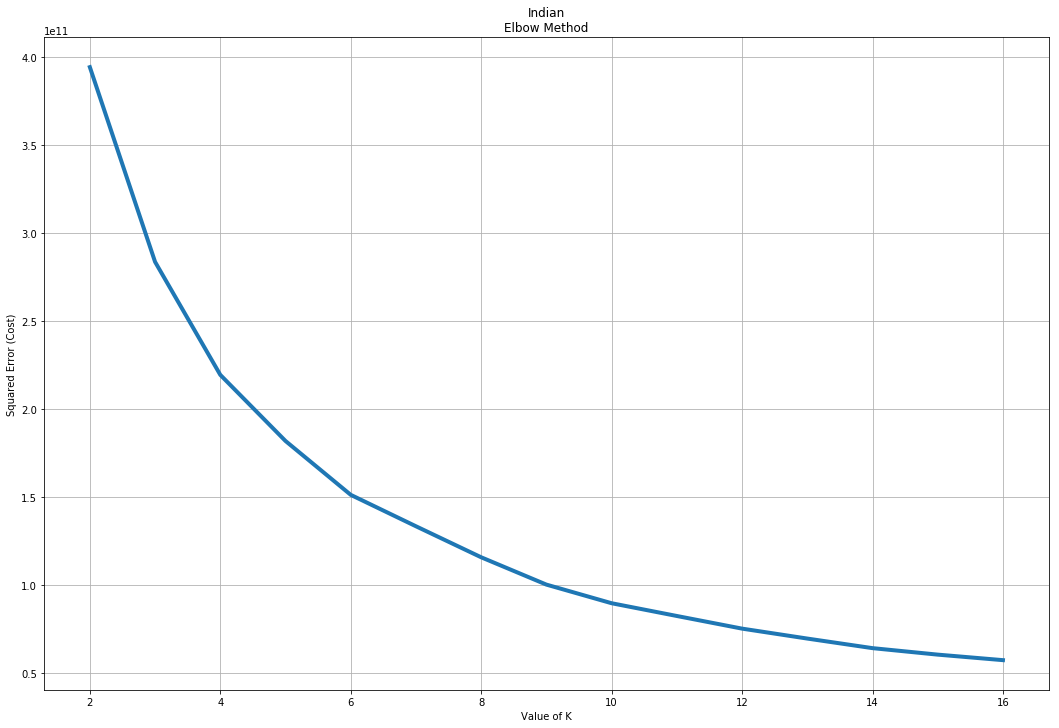

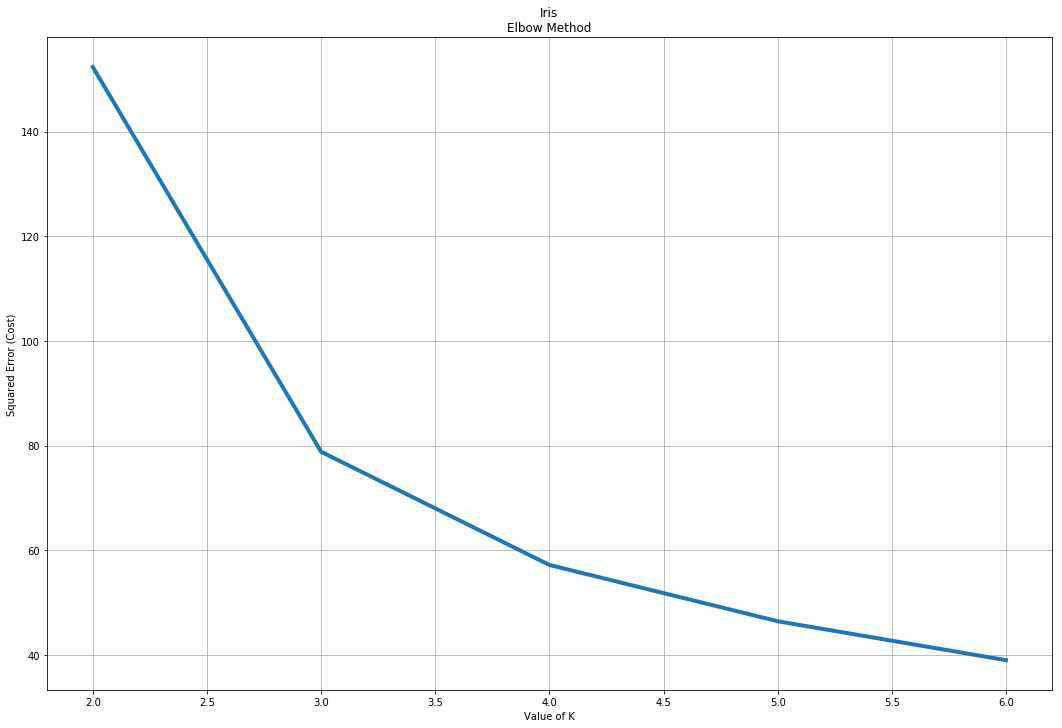

In [210]:
cost = {}
for name, data, iterable in [("indian", indian_df, range(2,17)), ("iris", iris_unnamed, range(2,7))]:
    cost[name] = []
    x = data.iloc[:, :-1]
    for num_clusters in iterable:
        km = KMeans(n_clusters=num_clusters, max_iter=500)
        km.fit(x)
        cost[name].append(km.inertia_)
    plt.figure(figsize=(18,12))
    plt.title(f"{name[0].upper()}{name[1:]}\nElbow Method")
    plt.xlabel("Value of K")
    plt.ylabel("Squared Error (Cost)")
    plt.plot(iterable, cost[name], linewidth=4)
    plt.grid()
    plt.show()

b)

Comments about 1a

Question 2)

a)

First, lets add the necessary functions for PCA and LDA (as taken from HW 3)

In [12]:
def scale(df, scaler="MinMax"):
    """Scale the dataframe using the scaler specified and return the newly scaled dataframe
    """
    inputs = df.iloc[:, :-1].to_numpy()
    if scaler == "MinMax":
        scale = MinMaxScaler()
    elif scaler == "Standard":
        scale = StandardScaler()
    else:
        raise ValueError(f"Unsupported scaler {scaler}")
    scale.fit(inputs.astype(float))
    inputs = scale.transform(inputs)
    
    scaled_df = pd.DataFrame(data=inputs)

    scaled_df["target"] = df["target"]
    
    return scaled_df

In [13]:
def fit_pca(df, **kwargs):
    """Apply and return the prinicpal component fit for the dataframe
    """
    n_components = kwargs.get("n_components", len(df.columns)-1)
    
    inputs = df.iloc[:, :-1].to_numpy()
    
    pca = PCA(n_components=n_components)
    pc = pca.fit(inputs)
    
    return pc

In [14]:
def transform_pca(df, pc):
    """Use the given principal component fit to transform the dataframe and return the transformed dataframe
    """
    inputs = df.iloc[:, :-1].to_numpy()
    transformed_df = pd.DataFrame(data=pc.transform(inputs))
    transformed_df.columns = [*map(lambda y : f"PC-{y}", list(range(1, pc.n_components + 1)))] 
    transformed_df["target"] = df["target"]
    return transformed_df

In [15]:
def perform_pca(df, **kwargs):
    """Single function call to scale, fit and transform the data with pca
    """
    df_scaled = scale(df)
    pc = fit_pca(df_scaled, **kwargs)
    df_pca = transform_pca(df_scaled, pc)
    
    return df_pca

In [133]:
def perform_lda(df, **kwargs):
    """Perform linear discriminant analysis on the data and returned the transformed data
    """
    n_components = kwargs.get("n_components", len(np.unique(df["target"].values))-1)
    
    inputs = df.iloc[:, :-1].to_numpy()
    targets = np.array(df["target"].values)

    lda = LinearDiscriminantAnalysis(n_components=n_components)
    transform_df = pd.DataFrame(data=lda.fit(inputs, targets).transform(inputs))
    transform_df.columns = [f"LD-{i}" for i in range(len(transform_df.columns))]
    transform_df["target"] = df["target"]
    
    return transform_df

First, lets setup all the input parameters.

In [204]:
num_clusters = {"indian": 8,
            "iris": 4}
dfs = {"iris_PCA_2": perform_pca(iris_unnamed, n_components=2),
      "iris_LDA_2": perform_lda(iris_unnamed, n_components=2),
      "iris_None_None": iris_unnamed,
      "indian_PCA_2": perform_pca(indian_df, n_components=4),
      "indian_LDA_2": perform_lda(indian_df, n_components=15),
      "indian_None_None": indian_df
    }
clustering_metrics = ["cosine", "euclidean"]
clustering = ["KMeans", "Hierachy"]

Now, lets setup the necessary functions for running and plotting the clustering techniques.

In [80]:
def run_cluster(data, num_clusters, clusterer, metric):
    x = data.iloc[:, :-1]
    if clusterer == "KMeans":
        cluster = KMeans(n_clusters=num_clusters, n_jobs=3, random_state=42)
        cluster.fit(x)
    else:
        cluster = hierarchy.linkage(x, metric=metric)
    return cluster

In [105]:
def plot_cluster(cluster, clusterer, data, name, **kwargs):
    if clusterer == "KMeans":
        plot_kmeans(cluster, data, name, **kwargs)
    else:
        plot_hierarchy(cluster, data, name, **kwargs)
    return

In [147]:
def plot_kmeans(cluster, data, name, **kwargs):
    def get_title(name, num_clusters, dim_red, metric):
        title = f"KMeans Clustering\nDataset: {name} - Number of Clusters: {num_clusters}\n"
        title += f"Dimensionality Reduction: {dim_red}"
        return title
    
    def get_axes_labels(name, dim_red):
        if dim_red == "PCA":
            xlabel = "PCA - 1"
            ylabel = "PCA - 2"
        elif dim_red == "LDA":
            xlabel = "LDA - 1"
            ylabel = "LDA - 2"
        else:
            if name == "iris":
                xlabel = "Petal Length"
                ylabel = "Petal Width"
            else:
                xlabel = "Band - 0"
                ylabel = "Band - 1"
        return xlabel, ylabel
    
    def get_cols(name, dim_red):
        if dim_red == "PCA":
            xcol = "PC-1"
            ycol = "PC-2"
        elif dim_red == "LDA":
            xcol = "LD-0"
            ycol = "LD-1"
        else:
            if name == "iris":
                xcol = "petal length (cm)"
                ycol = "petal width (cm)"
            else:
                xcol = 0
                ycol = 1
        return xcol, ycol
                
    def get_kmeans_output(km, data):
        centroids = pd.DataFrame(km.cluster_centers_, columns=data.columns[:-1])
        labels = np.array(km.labels_)
        return centroids, labels
    
    num_clusters = kwargs.get("num_clusters", "")
    dim_red = kwargs.get("dim_red", "")
    metric = kwargs.get("metric", "")
    targets = kwargs.get("targets", data.loc[:, "target"].to_numpy())
    
    title = get_title(name, num_clusters, dim_red, metric)
    xlabel, ylabel = get_axes_labels(name, dim_red)
    xcol, ycol = get_cols(name, dim_red)
    centroids, labels = get_kmeans_output(cluster, data)
    
    colors = np.array([mcolors["maroon"], mcolors["gold"], mcolors["cyan"], mcolors["lawngreen"],
                       mcolors["darkgreen"], mcolors["dodgerblue"], mcolors["slategrey"], mcolors["royalblue"],
                       mcolors["rebeccapurple"], mcolors["violet"], mcolors["deeppink"], mcolors["coral"], 
                       mcolors["darkgoldenrod"], mcolors["yellow"], mcolors["indigo"], mcolors["lightseagreen"],
                       mcolors["thistle"]])
    
    fig, ax = plt.subplots(2, figsize=(18,12))
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)
    ax[0].grid(True)
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel(ylabel)
    ax[1].grid(True)
    fig.suptitle(title)
    ax[0].set_title("True Class Labels")
    ax[1].set_title("Predicted Cluster Labels")
    ax[0].scatter(data[xcol], data[ycol], c=colors[data.loc[:, "target"].to_numpy()], label=targets, s=50, alpha=0.5)
    ax[0].scatter(centroids[xcol], centroids[ycol], c="k", s=150, alpha=0.7)
    ax[1].scatter(data[xcol], data[ycol], c=colors[labels], label=labels, s=50, alpha=0.5)
    ax[1].scatter(centroids[xcol], centroids[ycol], c="k", s=150, alpha=0.7)
    #ax[0].legend()
    #ax[1].legend()
    return

In [206]:
def plot_hierarchy(cluster, data, name, **kwargs):
    def get_title(name, num_clusters, dim_red, metric):
        title = f"Hierarchical Clustering\nDataset: {name} - Number of Clusters: {num_clusters}\n"
        title += f"Dimensionality Reduction: {dim_red}"
        return title
    
    num_clusters = kwargs.get("num_clusters", "")
    dim_red = kwargs.get("dim_red", "")
    metric = kwargs.get("metric", "  ")
    
    title = get_title(name, num_clusters, dim_red, metric)

    fig, ax = plt.subplots(figsize=(25,12))
    ax.set_xlabel("Data Points")
    ax.set_ylabel(f"{metric[0].upper()}{metric[1:]}")
    ax.set_title(title)
    if name == "indian":
        return
    dn = hierarchy.dendrogram(cluster, leaf_font_size=12, ax=ax)
    return

Now, loop over the different setups and run the clustering techniques

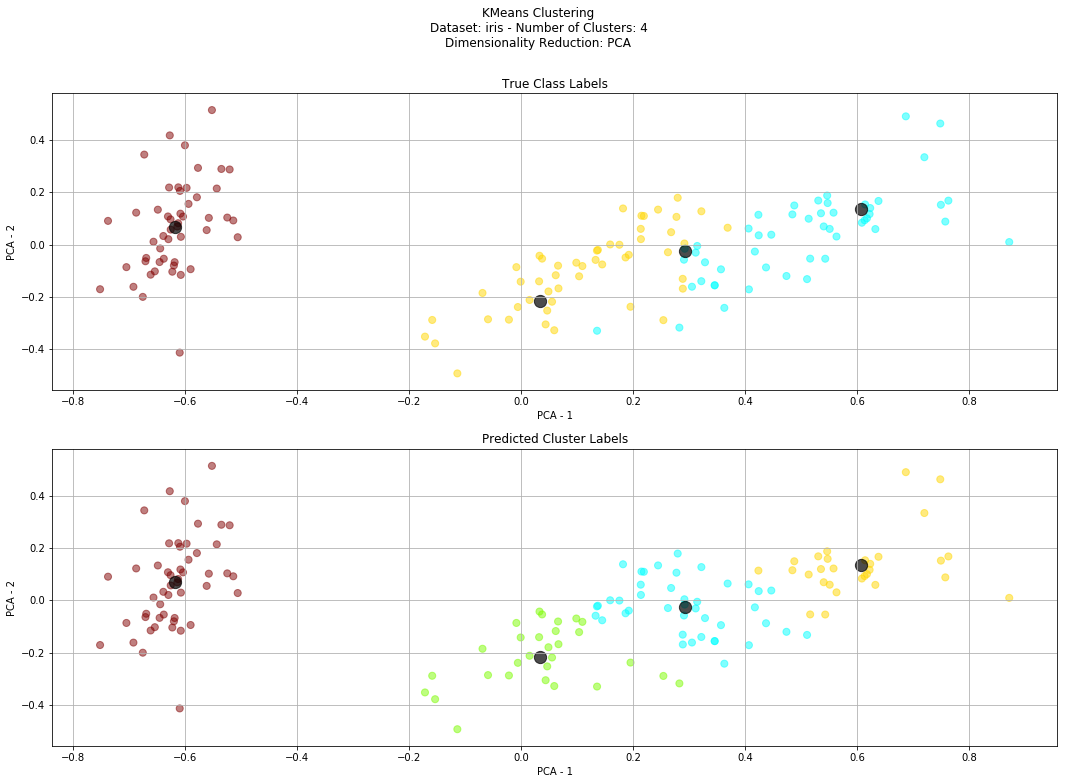

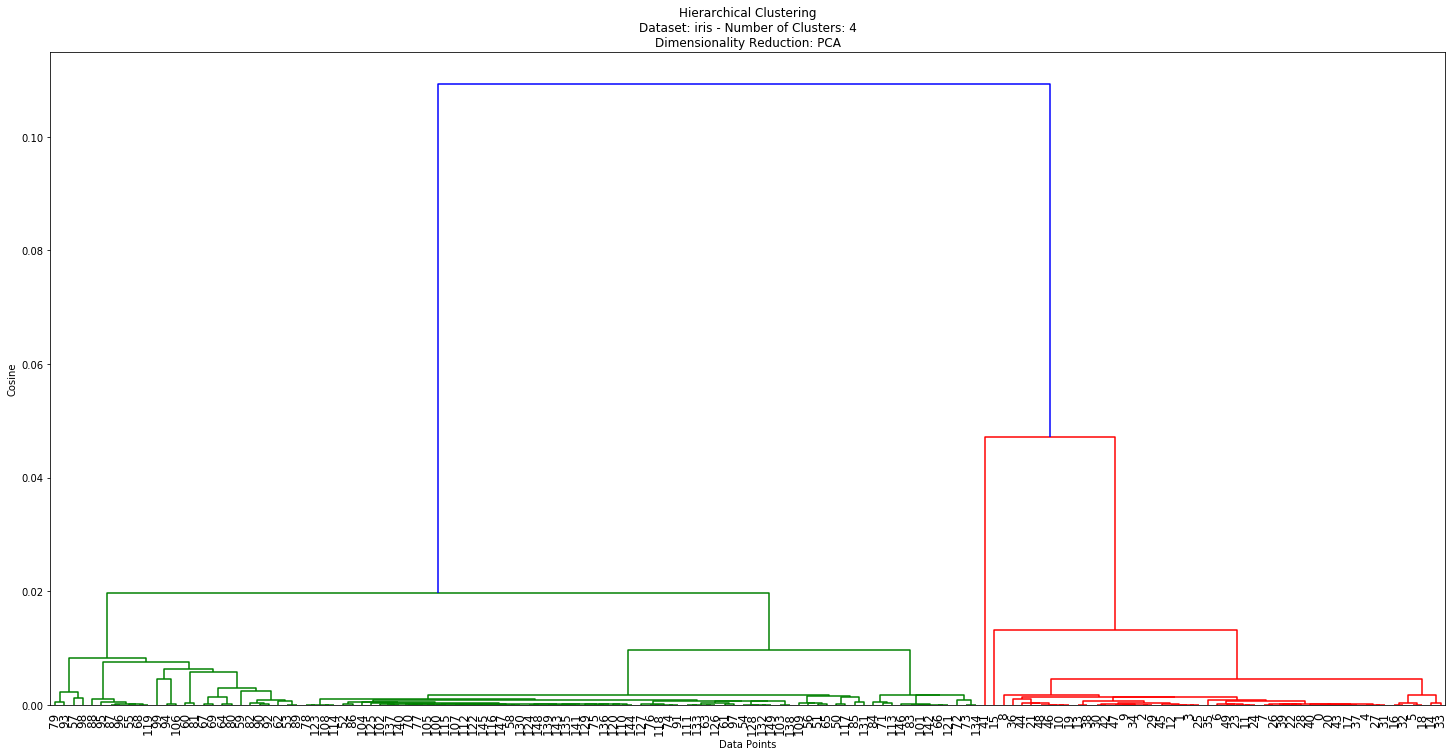

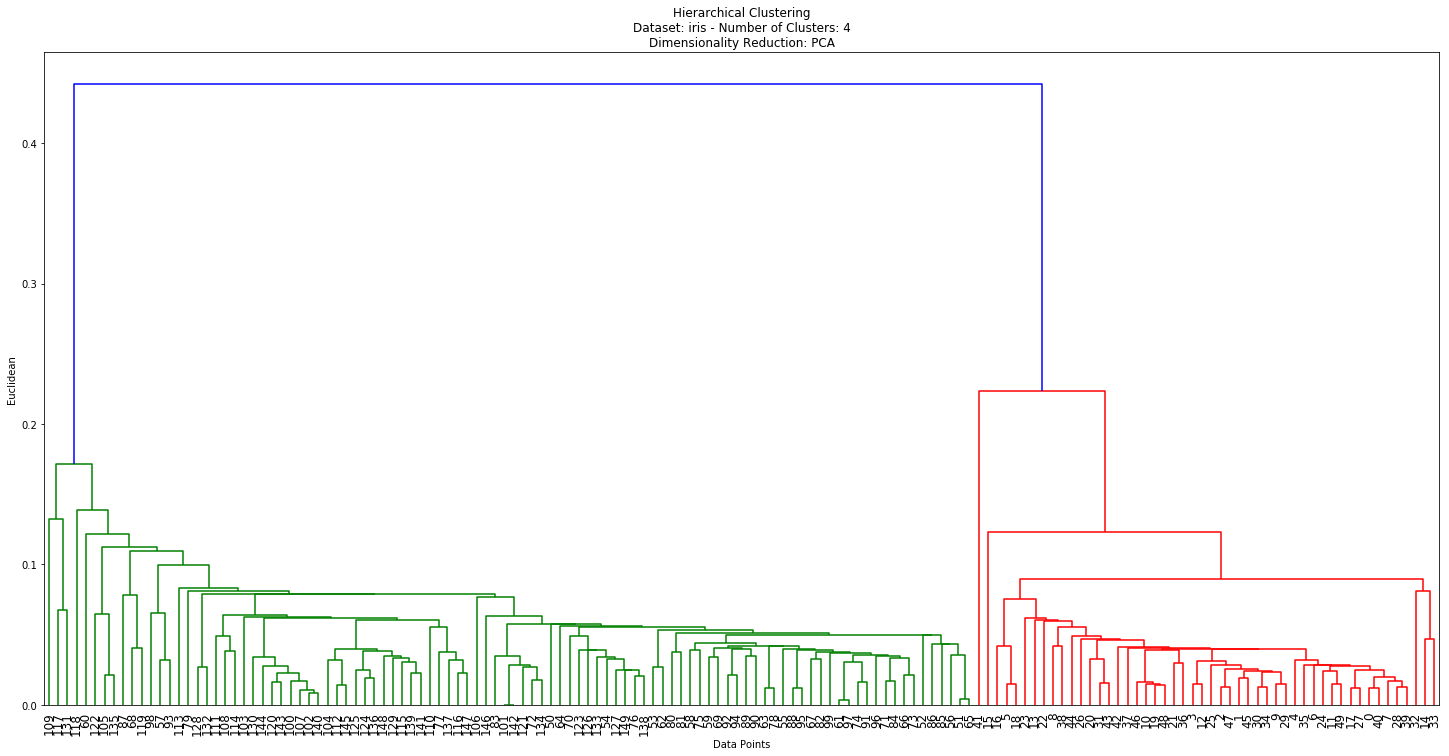

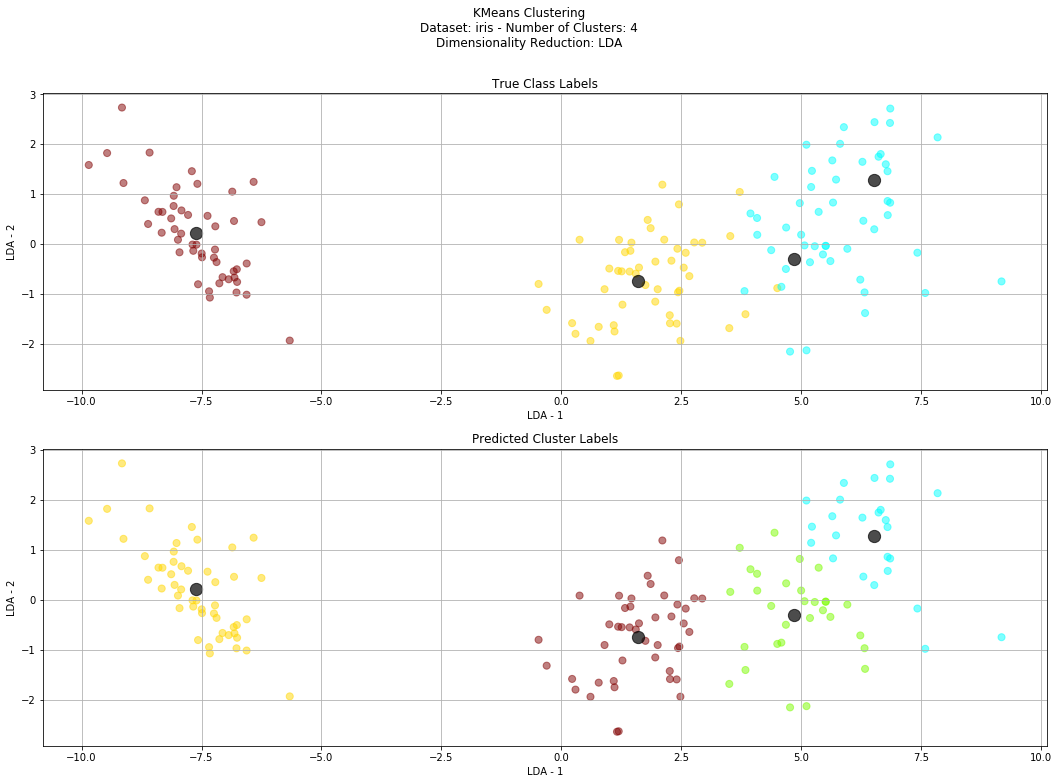

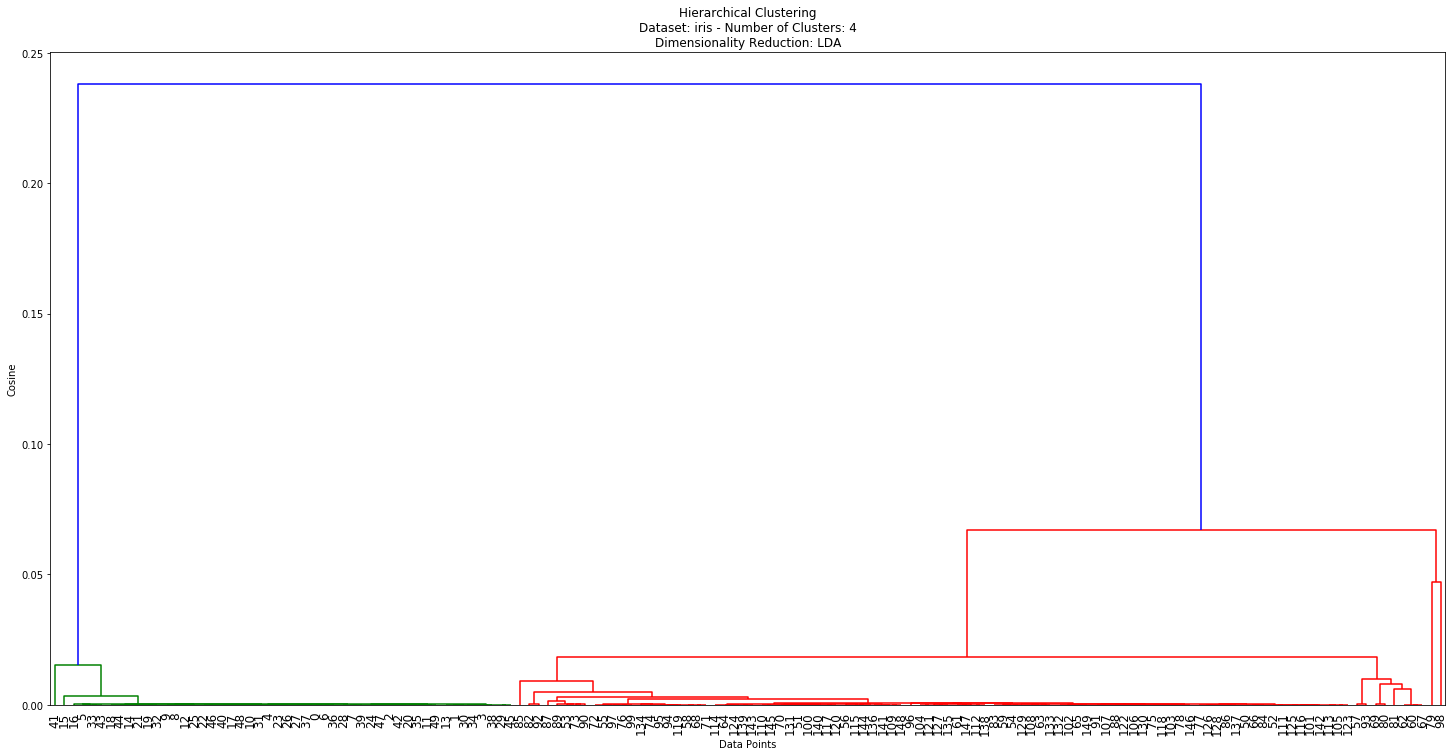

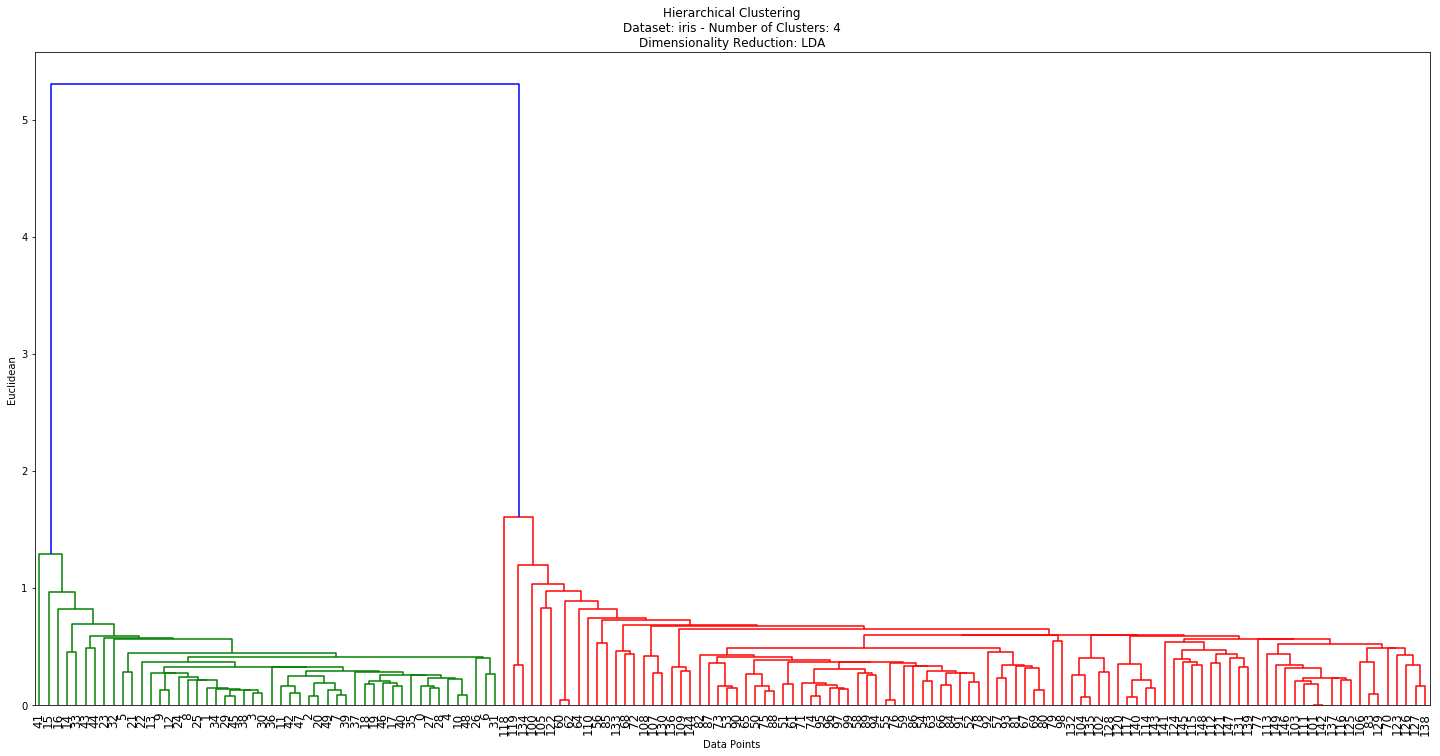

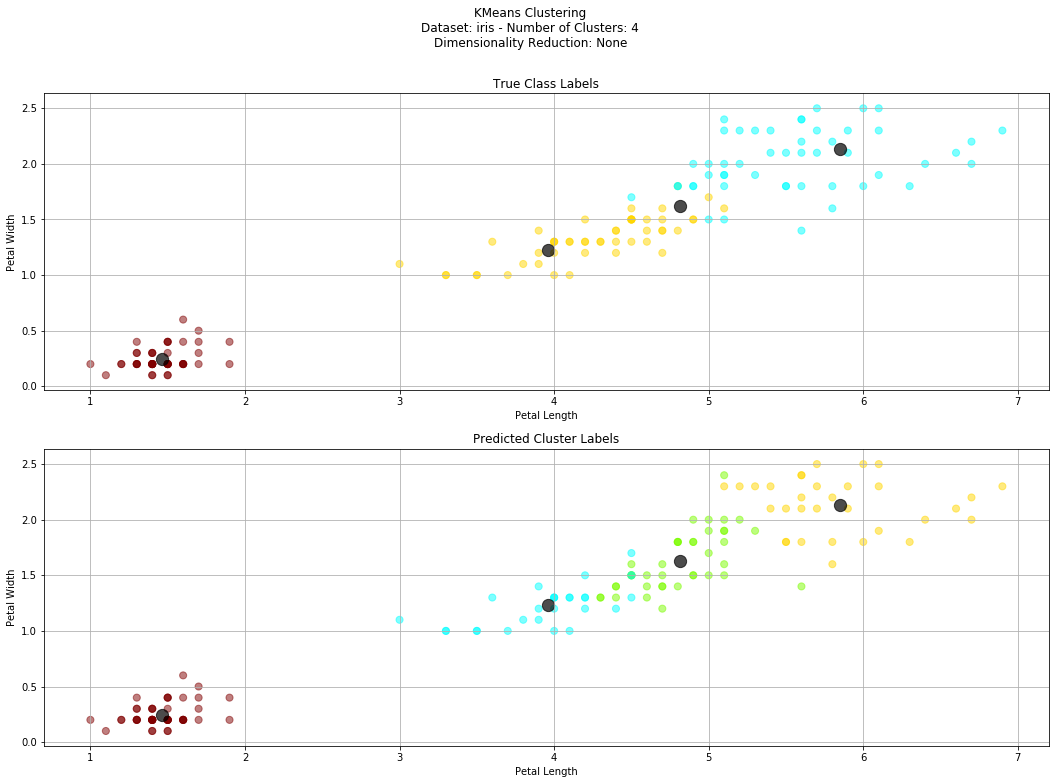

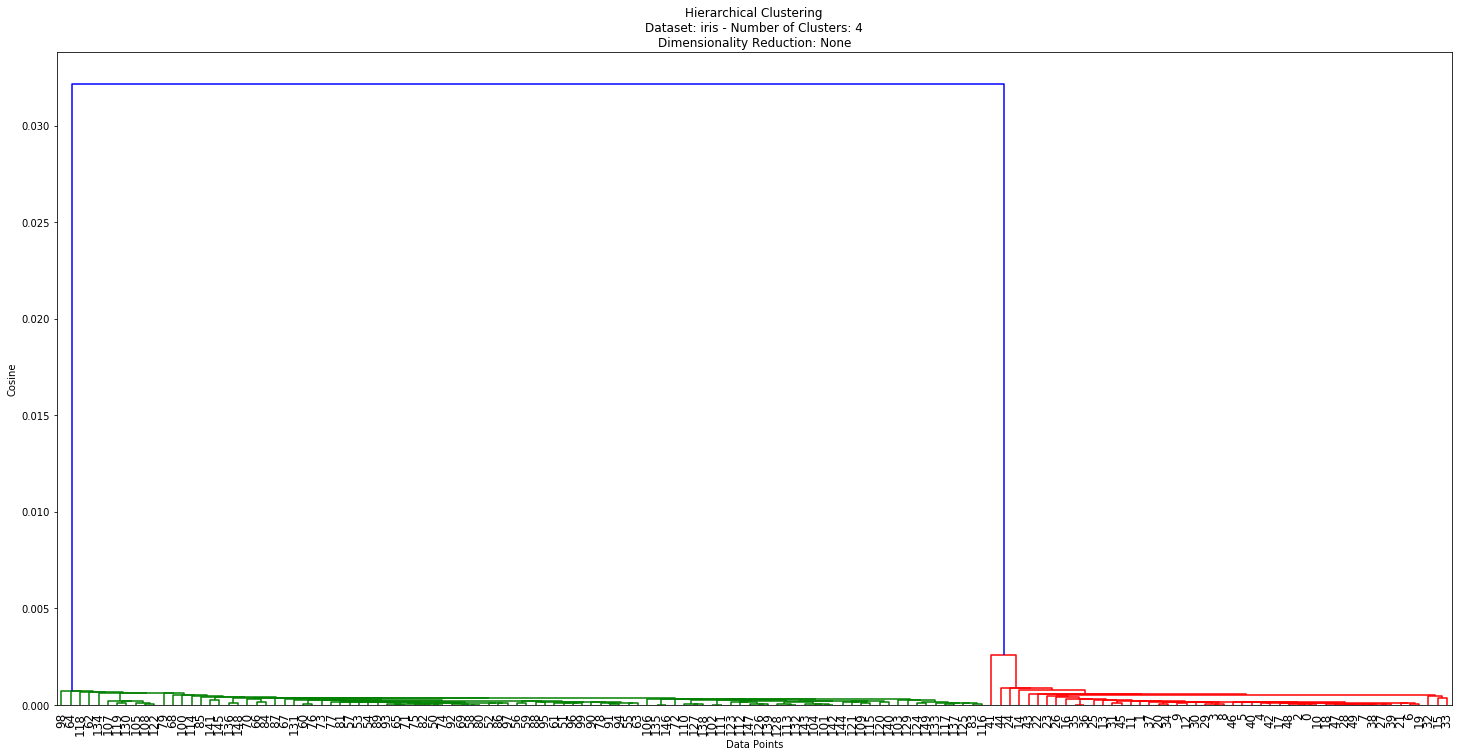

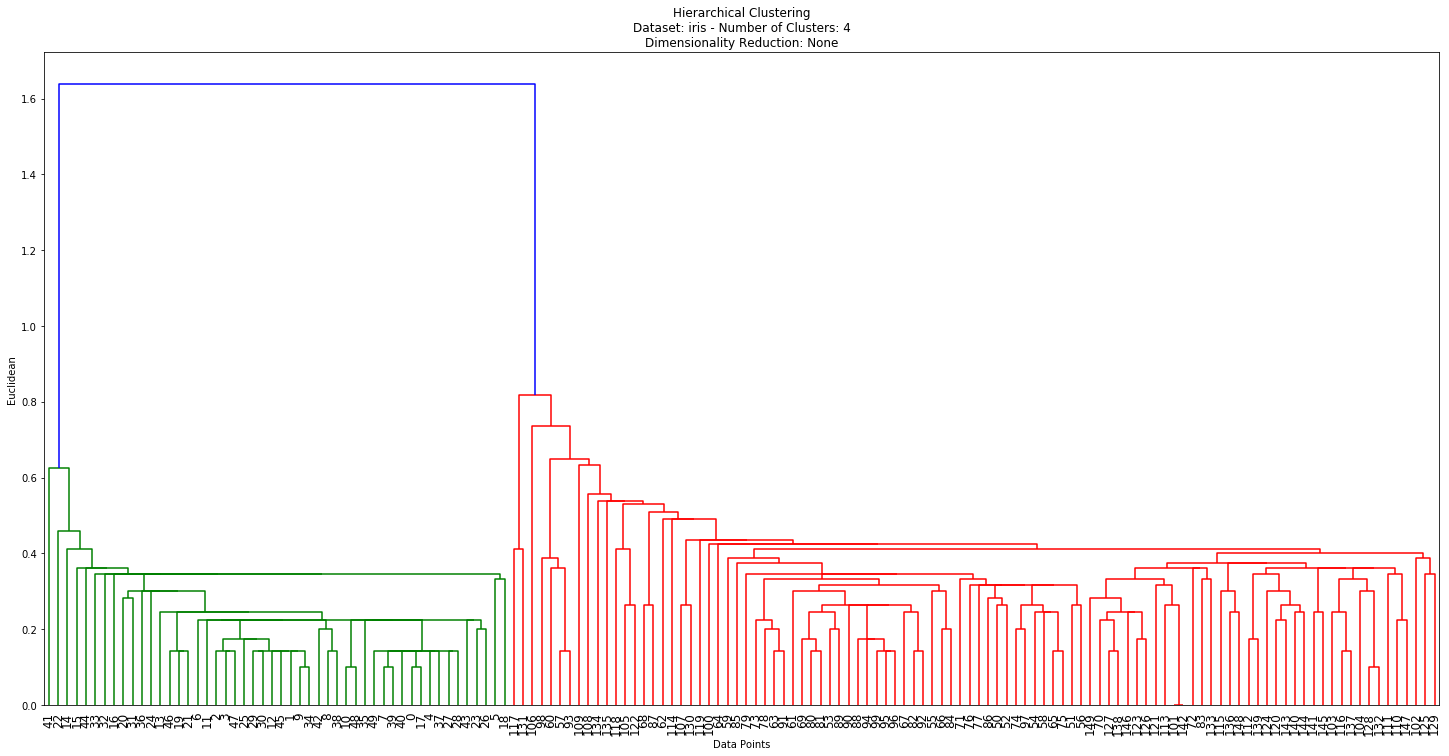

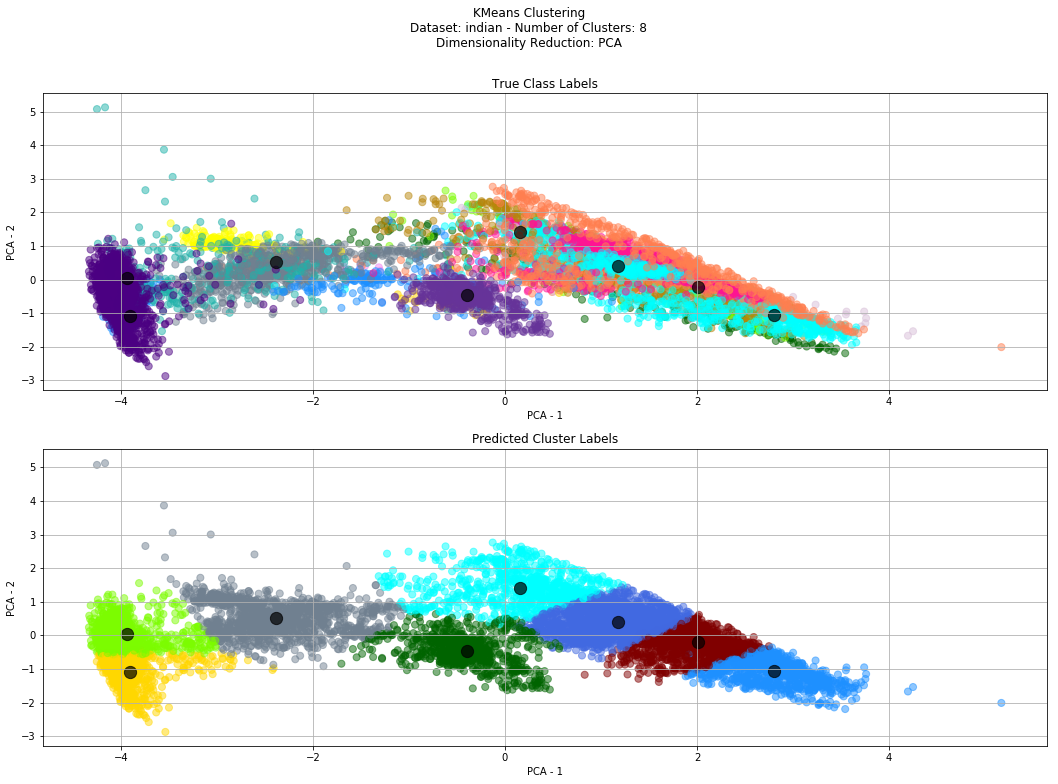

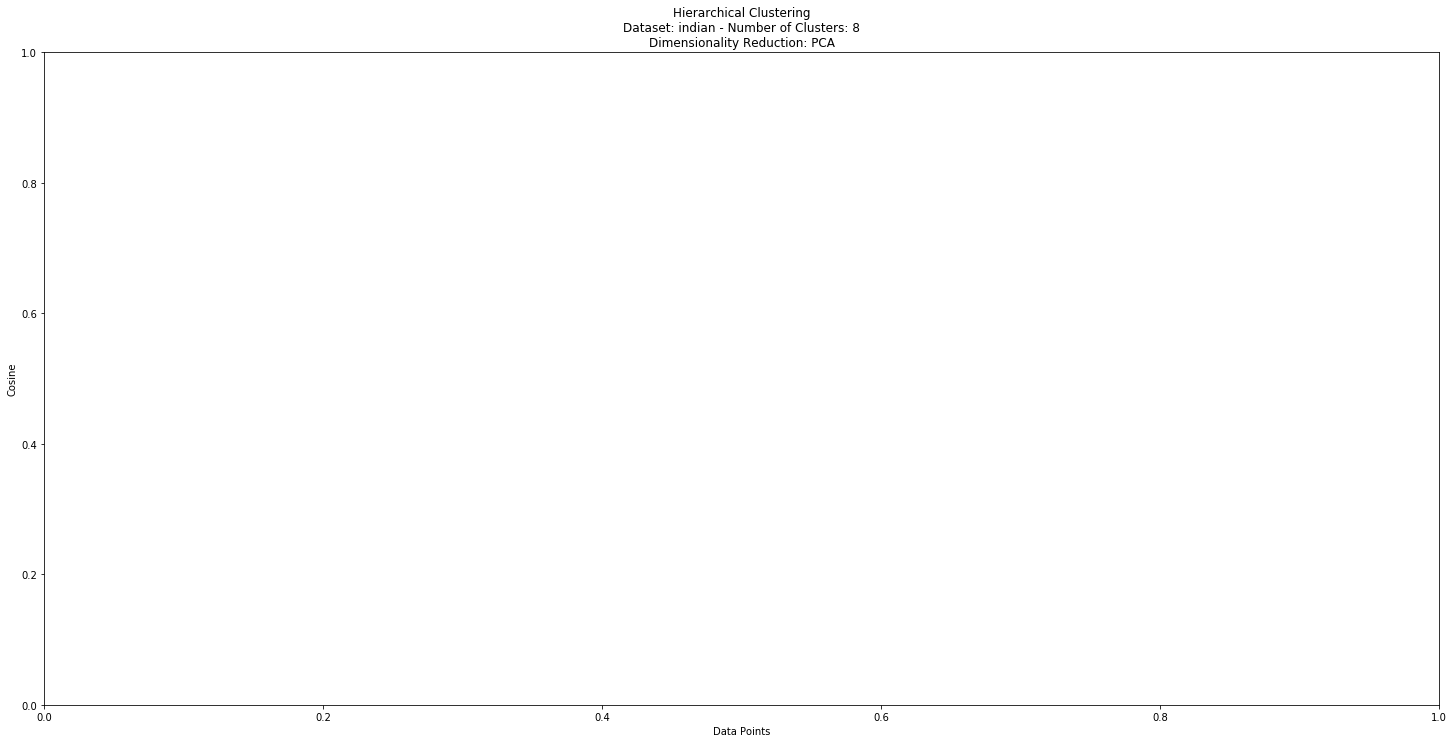

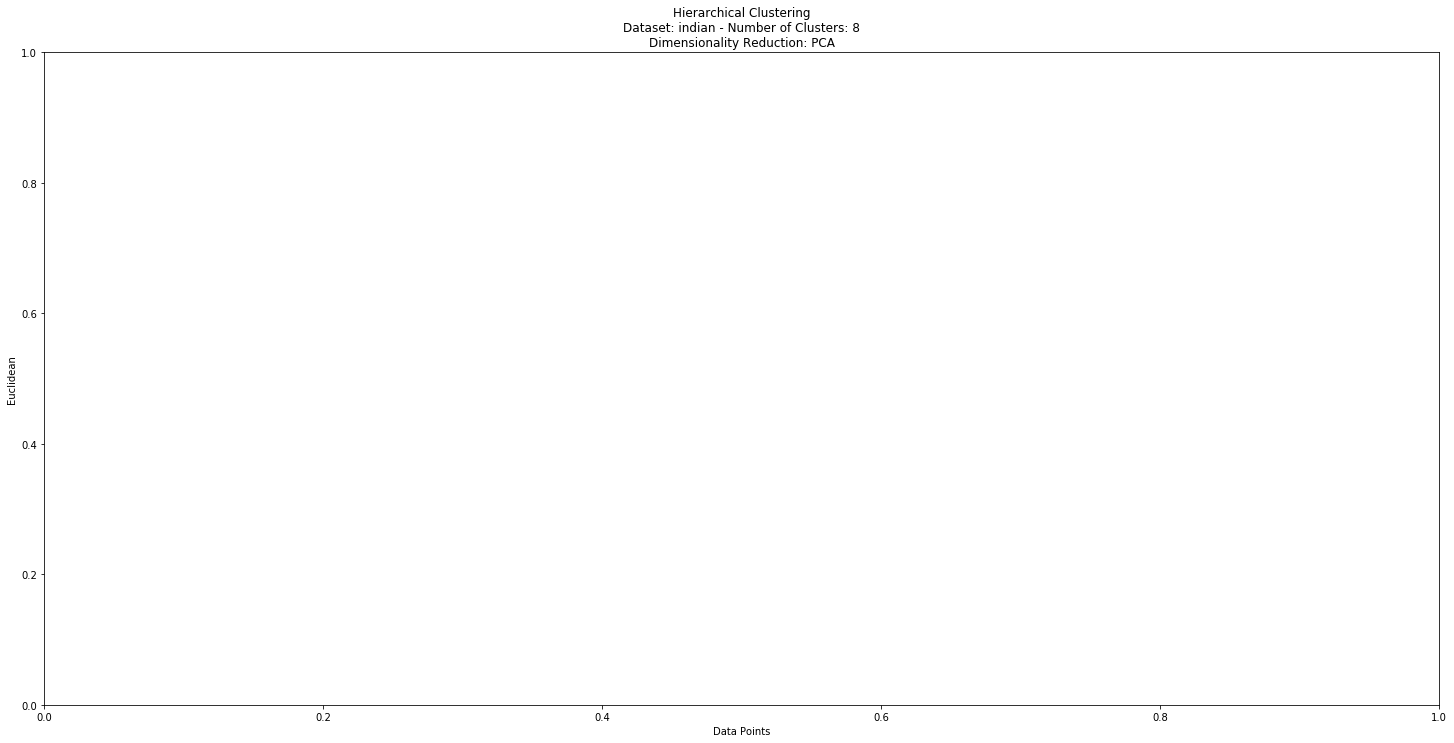

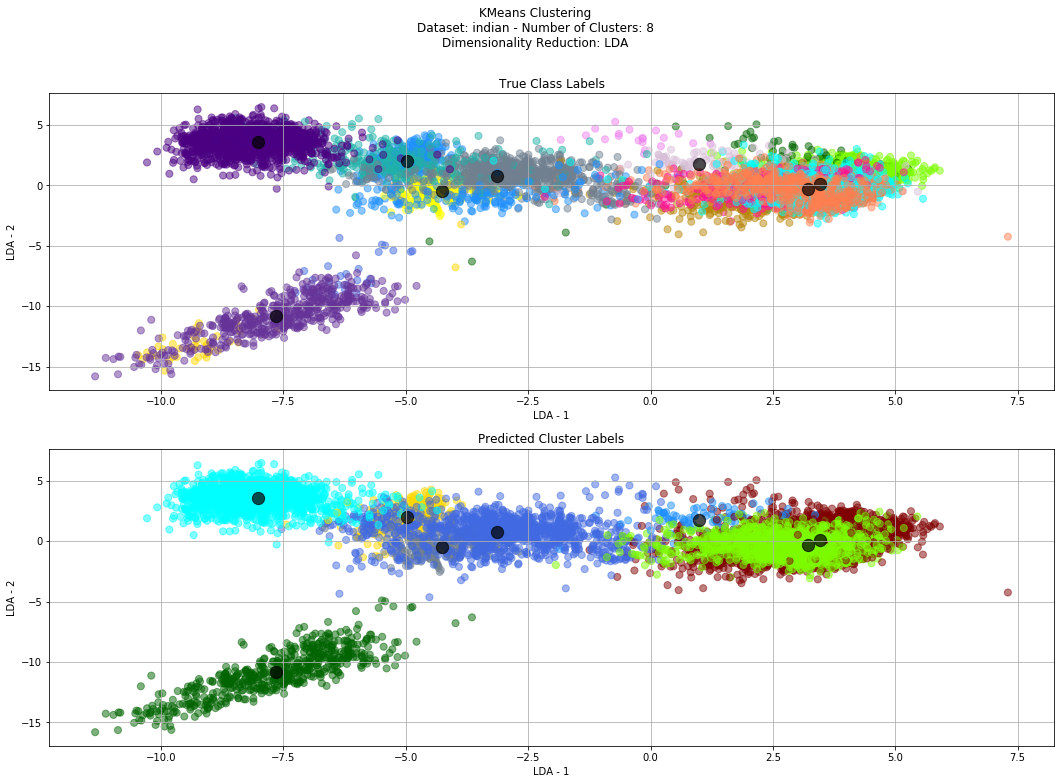

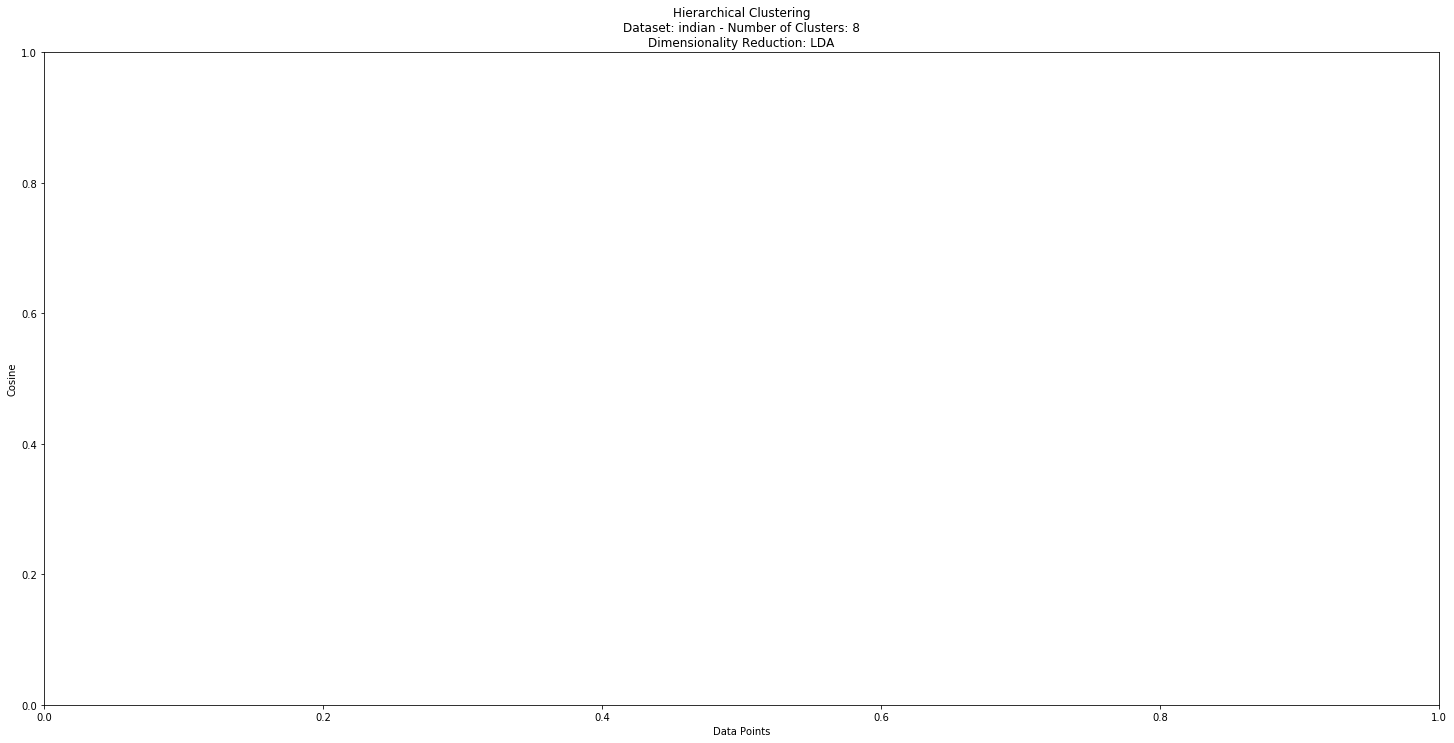

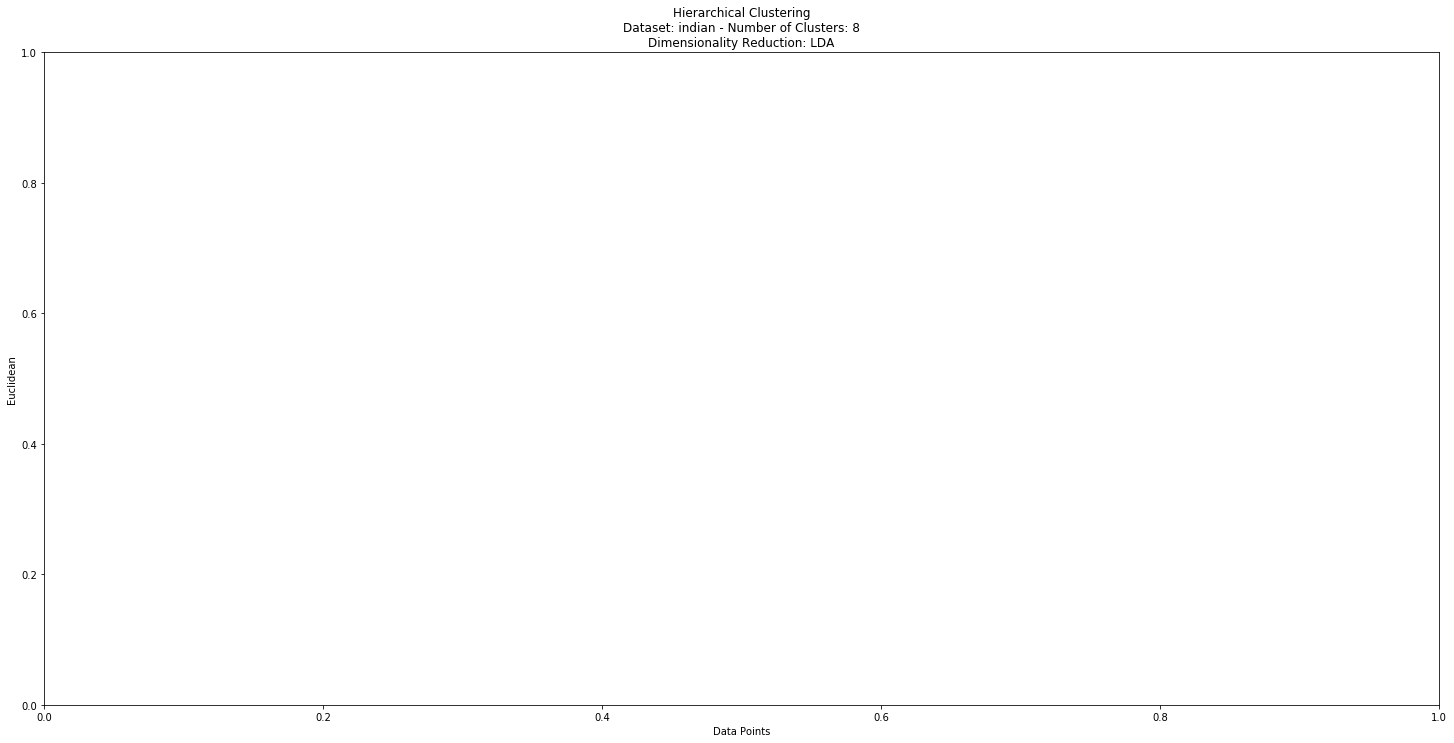

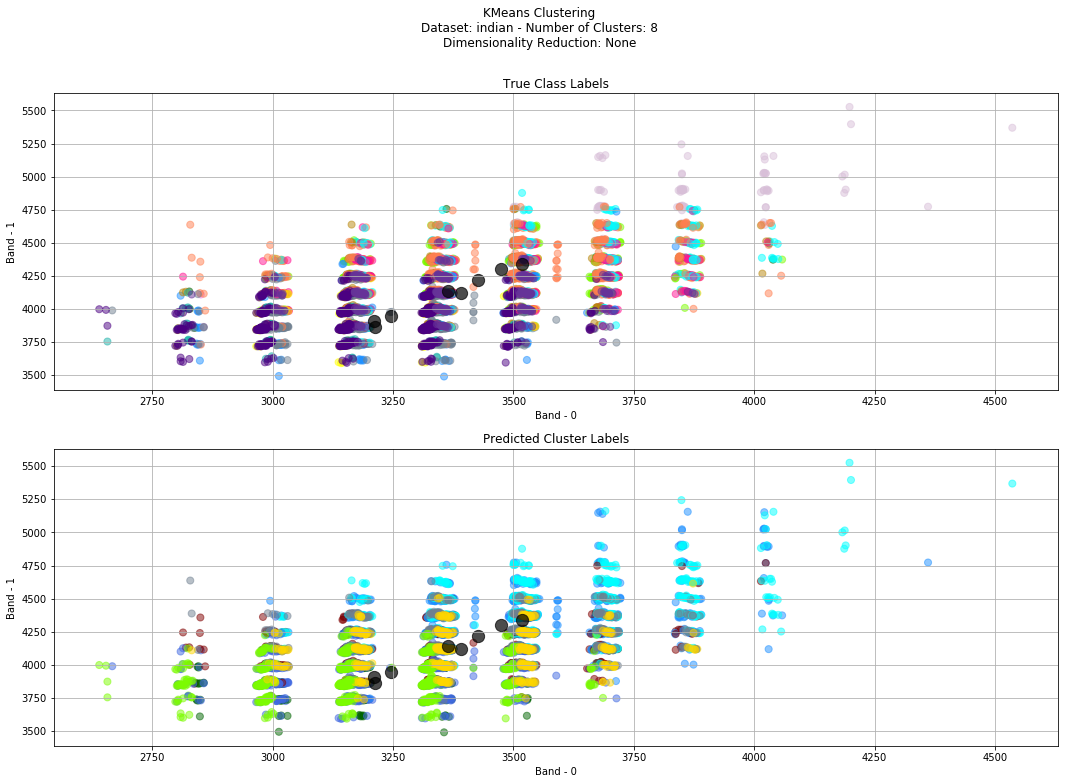

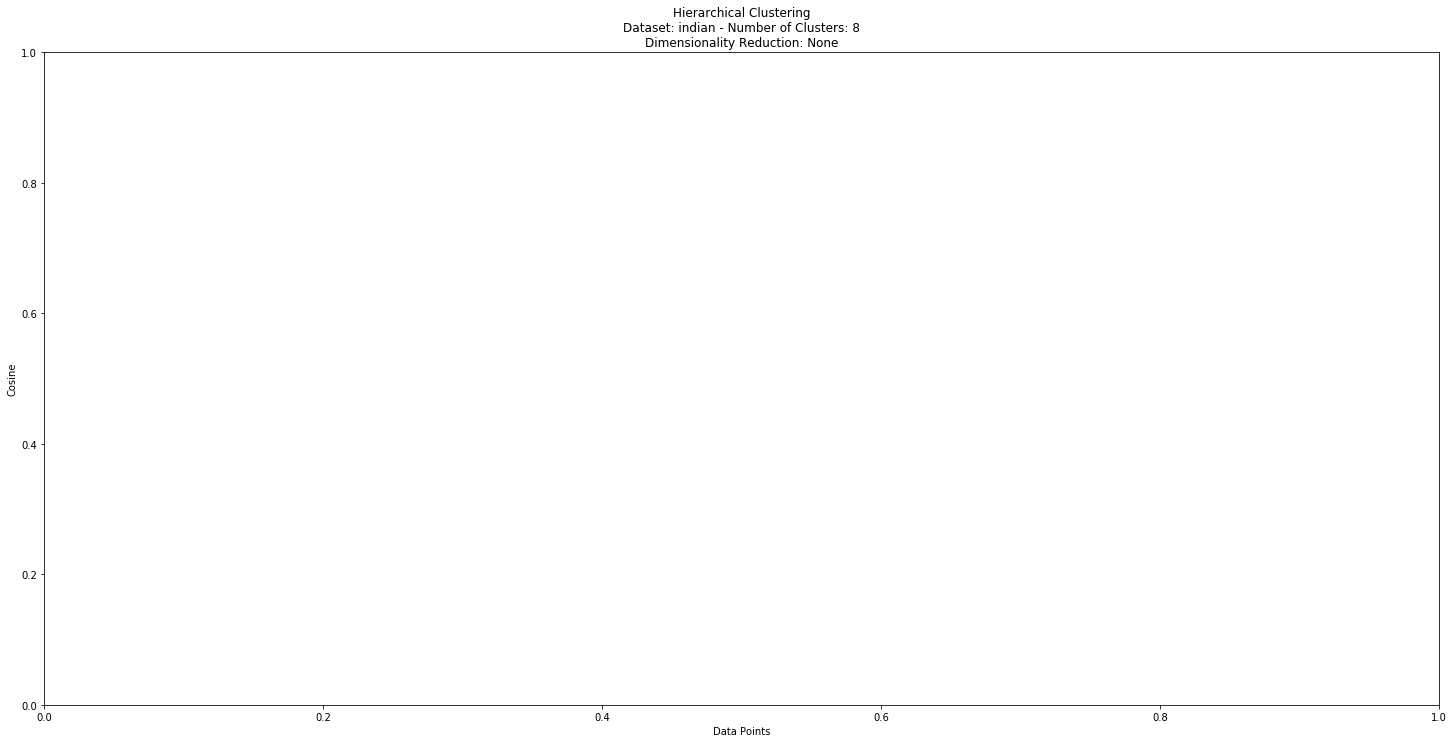

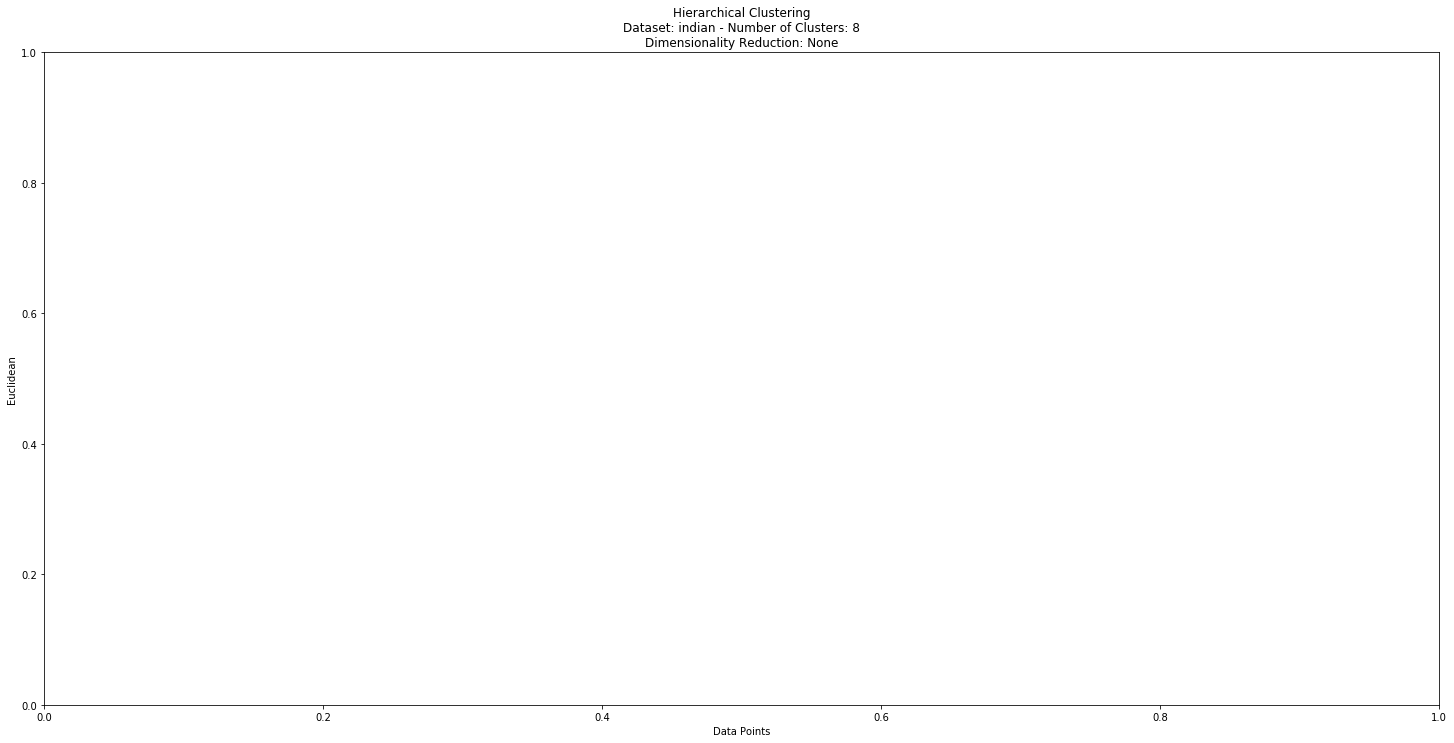

In [207]:
#total_output = {}
# loop over each dataframe
for key, df in dfs.items():
    name, dim_red, dim_num = key.split("_")
    # intialize sub dictionary for each classifier performance
    #output_clusterer = {}
    #loop over each model and save performance to the sub dictionary for classifiers
    for clusterer in clustering:
        for clust_metric in clustering_metrics:
            if clust_metric == "cosine" and clusterer == "KMeans":
                continue
            #out_key = "_".join([clusterer, clust_metric])
            #print(f"===={key}-{dim_red}-{clusterer}-{clust_metric}====")
            #output_clusterer[out_key] = run_cluster(df, num_clusters[name], clusterer, clust_metric)
            cluster = run_cluster(df, num_clusters[name], clusterer, clust_metric)
            if name == "iris":
                targets = iris_df.loc[:, "target"].to_numpy()
            else:
                targets = df.loc[:, "target"].to_numpy()
            plot_cluster(cluster, clusterer, df, name,
                         num_clusters=num_clusters[name], 
                         dim_red=dim_red, metric=clust_metric,
                         targets=targets)
    #add sub dictionary for classification to our total dictionary
    #total_output[key] = output_clusterer

Question 3)

a)

In [159]:
def partition_coefficient_score(x, predictions):
    total = 0
    for i in range(len(predictions)):
        for j in range(len(x)):
            if predictions[j] == i:
                total += 1
    return 1/len(x) * total

In [200]:
def print_validity_score(total_table, key):
    score_table = total_table[key]
    name, dim_red, dim_num = key.split("_")
    print(f"==== {name[0].upper()}{name[1:]} - {dim_red} Validity Table ====\n")
    table = []
    line = "S\K "
    for i in range(len(score_table["  DB"])):
        temp = " " + str(i+2)
        temp = temp.ljust(5)
        line += "|" + temp
    table.append(line)
    for index, scores in score_table.items():
        line = index
        for score in scores:
            temp = str(score)
            line += "|" + temp[:5]
        table.append(line)
    output = "\n".join(table)
    print(output)
    print("\n\n")
    return

In [199]:
metrics = {}
iterables = {"indian": range(2,17),
             "iris": range(2,7)}
for key, df in dfs.items():
    name, dim_red, dim_num = key.split("_")
    metrics[key] = {"  DB": [],
                    "SILH": [],
                    " PCI": []}
    x = df.iloc[:, :-1]
    for num_clusters in iterables[name]:
        km = KMeans(n_clusters=num_clusters, max_iter=500, random_state=42, n_jobs=3)
        km.fit(x)
        predictions = km.predict(x)
        metrics[key]["  DB"].append(davies_bouldin_score(x, predictions))
        metrics[key]["SILH"].append(silhouette_score(x, predictions))
        #metrics[key][" PCI"].append(partition_coefficient_score(x, predictions))

In [201]:
for key, df in dfs.items():
    print_validity_score(metrics, key)

==== Iris - PCA Validity Table ====

S\K | 2   | 3   | 4   | 5   | 6   
  DB|0.435|0.609|0.682|0.739|0.789
SILH|0.665|0.565|0.526|0.448|0.429
 PCI



==== Iris - LDA Validity Table ====

S\K | 2   | 3   | 4   | 5   | 6   
  DB|0.296|0.487|0.694|0.828|0.862
SILH|0.768|0.655|0.584|0.453|0.406
 PCI



==== Iris - None Validity Table ====

S\K | 2   | 3   | 4   | 5   | 6   
  DB|0.404|0.661|0.780|0.805|0.914
SILH|0.681|0.552|0.498|0.488|0.364
 PCI



==== Indian - PCA Validity Table ====

S\K | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10  | 11  | 12  | 13  | 14  | 15  | 16  
  DB|0.493|0.814|0.848|0.798|0.813|0.840|0.846|0.942|0.989|0.927|0.922|0.902|0.933|0.968|0.975
SILH|0.647|0.462|0.419|0.430|0.417|0.395|0.372|0.346|0.336|0.345|0.349|0.351|0.338|0.312|0.313
 PCI



==== Indian - LDA Validity Table ====

S\K | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10  | 11  | 12  | 13  | 14  | 15  | 16  
  DB|1.274|1.032|1.103|1.267|1.425|1.416|1.293|1.358|1.370|1.523|1.569|1.662|1.695|

Based on the validity tables above, we can determine the best number of clusters based on each metric. For Davies Bouldin (DB) we want the lowest value, for Silhouette (SILH) we want the largest value and for Partition Coefficient Index (PCI) we also want the largest value.  

In [221]:
best = [
        ["Iris", "None", 2, 2, 0],
        ["Iris", "PCA", 2, 2, 0],
        ["Iris", "LDA", 2, 2, 0],
        ["Indian", "None", 11, 2, 0],
        ["Indian", "PCA", 2, 2, 0],
        ["Indian", "LDA", 3, 3, 0]
       ]
best_cluster = pd.DataFrame(best)
best_cluster.columns = ["Dataset", "Dim Red", "DB", "SILH", "PCI"]
best_cluster.set_index(["Dataset", "Dim Red"], inplace=True)

print(best_cluster)

                 DB  SILH  PCI
Dataset Dim Red               
Iris    None      2     2    0
        PCA       2     2    0
        LDA       2     2    0
Indian  None     11     2    0
        PCA       2     2    0
        LDA       3     3    0


It is important to note what each index measures to properly understand why it validates the number of clusters that it does. 

For the iris dataset, it makes no difference which metric or which dimensionality reduction approach we use. The answer is always just 2 clusters. This is because...   
   
For the indian dataset, the metrics did in fact vary a little with the dimensionality reduction approach used. The only big difference is that without dimensionality reduction, the DB score proposed 11 clusters while the other metrics and dimensionality reductions chose either 2 or 3. 

b)

i)  
comments  
  
ii)  
comments